In [1]:
import numpy as np 
import pandas as pd 
import h5py
import uproot
import glob 
import matplotlib.pyplot as plt
import tqdm
from utils import ParticleCode

# Load your custom style 
plt.style.use('./cfg/my_custom_plot.mplstyle')

# use these lines on top of your matplotlib script
import matplotlib.ticker
class MyLocator(matplotlib.ticker.AutoMinorLocator):
    def __init__(self, n=4):
        super().__init__(n=n)
matplotlib.ticker.AutoMinorLocator = MyLocator        
 
# Now use matplotlib as usual.       
import matplotlib.pyplot as plt
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True

In [2]:
# Geometry for MiniRun 5
anode_xs = np.array([-63.931, -3.069, 3.069, 63.931])
anode_ys = np.array([-19.8543, 103.8543])  # two ys
anode_zs = np.array([-64.3163, -2.6837, 2.6837, 64.3163])  # four zs

# hit coordinates are in cm
detector_center = (0, 0, 0)
anode_ys = anode_ys - 42

In [3]:
f_directory = "/global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.flow.beta2a/FLOW/0000000/"
plot_dir = "./plots/"

# Get PDG codes
neutron_pdg = ParticleCode().neutron
proton_pdg = ParticleCode().proton
numu_pdg = ParticleCode().numu
nue_pdg = ParticleCode().nue
neutron_mass = ParticleCode().neutron_mass
proton_mass = ParticleCode().proton_mass


# TO DO: Use hadron subprocess label! 
# G4 Subprocess labels
HadronElastic = 111
HadronInelastic = 121
HadronCapture = 131
HadronChargeExchange = 161
NeutronKiller=403
EMScintillation = 22 
GeneralStepLimit=401
Hadronic = 4
Decay = 6 


# Number of files

n_files = 20

## Declare arrays to store data

In [4]:
nu_x = []
nu_y = []
nu_z = []
numu_CC = []
numu_NC = []
nue_CC = []
nue_NC = []
Ar_id = [] 
neutron_energy = [] 
n_neutrons = []
n_end_neutrons = [] 
neutrons_traj_id = []
neutron_start_x = []
neutron_start_y = []
neutron_start_z = []
neutron_end_x = []
neutron_end_y = []
neutron_end_z = []
neutron_start_t = []  
neutron_end_t = []

n_hadronic_E = []
n_decay_E = []
n_elastic_E = []
n_inelastic_E = []
n_capture_E = []
n_ce_E = [] 
n_killer_E = []
n_general_E = []
neutron_counter = 0  
sample_for_evd = []
n_traj_E = []
n_process_type = [] 
n_em_E = [] 
n_fiducial_E = [] 
neutron_end_volume = [] 


neutron_prim = []
neutron_prim_traj = []
neutron_sec_traj = []

proton_n_daughter_traj = []
photon_n_daughter_traj = [] 

In [5]:
file_counter=0
for filename in glob.glob(f_directory+'*.hdf5'):
    #print(filename)
    f=h5py.File(filename,'r')

    # Nu interactions
    Interactions = f['mc_truth/interactions/data']

    # True Particle information 
    MCStack = f['mc_truth/stack/data']

    # True Particle Trajectories 
    Trajectories = f['mc_truth/trajectories/data']

    # Apply filter for interactions with Ar only and inside the detector (not FV!)
    Ar_id_temp = Interactions[(Interactions['target']==18) & 
                              (Interactions['x_vert'] >= anode_xs[0]) & (Interactions['x_vert'] <= anode_xs[3]) &
                              (Interactions['y_vert'] >= anode_ys[0]) & (Interactions['y_vert'] <= anode_ys[1]) &
                              (Interactions['z_vert'] >= anode_xs[0]) & (Interactions['z_vert'] <= anode_xs[3]) 
                              ]['vertex_id']
    
    # Masking out interactions
    int_mask = np.isin(Interactions['vertex_id'], Ar_id_temp)
    Interactions = Interactions[int_mask]
    mask_stack = np.isin(MCStack['vertex_id'], Ar_id_temp)
    mask_traj = np.isin(Trajectories['vertex_id'], Ar_id_temp)
    MCStack_ar = MCStack[mask_stack]
    Trajectories_ar = Trajectories[mask_traj]

    # Retrieve neutrino info 
    nu_x.extend(Interactions[Interactions['target']==18]['x_vert'])
    nu_y.extend(Interactions[Interactions['target']==18]['y_vert'])
    nu_z.extend(Interactions[Interactions['target']==18]['z_vert']) 
    numu_CC.extend(Interactions[(Interactions['isCC']==1) & 
                    (np.abs(Interactions['nu_pdg'])==numu_pdg)]['Enu']/1000.)
    numu_NC.extend(Interactions[(Interactions['isCC']==0) & 
                    (np.abs(Interactions['nu_pdg'])==numu_pdg)]['Enu']/1000.)
    nue_CC.extend(Interactions[(Interactions['isCC']==1)  & 
                    (np.abs(Interactions['nu_pdg'])==nue_pdg)]['Enu']/1000.)
    nue_NC.extend(Interactions[(Interactions['isCC']==0)  & 
                    (np.abs(Interactions['nu_pdg'])==nue_pdg)]['Enu']/1000.)

    # Final state - neutrons 
    temp_n_prim = MCStack_ar[(MCStack_ar['part_status'] == 1) & (MCStack_ar['part_pdg']==neutron_pdg)]
    neutron_prim.extend(temp_n_prim)
    temp_n_prim_traj = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) & (Trajectories_ar['primary']==True)]
    neutron_prim_traj.extend(temp_n_prim_traj)

    # Secondary neutrons 
    neutron_sec_traj.extend(Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) & (Trajectories_ar['primary']==False)])

    # Get secondary protons 
    proton_sec_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==proton_pdg) & 
                                      (Trajectories_ar['primary']==False) &
                                      (Trajectories_ar['start_process']==Hadronic) &
                                      (Trajectories_ar['start_subprocess']== HadronInelastic)]


    # Iterate over nu interactions with secondary protons
    # Store protons originated by neutrons 
    for ixn in proton_sec_temp['vertex_id']:
        protons_in_ixn = proton_sec_temp[proton_sec_temp['vertex_id'] == ixn]
        neutrons_in_ixn = temp_n_prim_traj[temp_n_prim_traj['vertex_id'] == ixn]
        protons_parent_id = protons_in_ixn['parent_id']
        mask_proton_n_daughter = np.isin(protons_parent_id,neutrons_in_ixn['traj_id'])
        proton_daughters_temp = protons_in_ixn[mask_proton_n_daughter]
        proton_n_daughter_traj.extend(proton_daughters_temp)


    # Iterate over nu interactions with secondary photons
    # Store photons originated by neutrons (Inelastic) 
    photon_sec_temp = Trajectories_ar[(Trajectories_ar['pdg_id']== ParticleCode().photon) & 
                                      (Trajectories_ar['primary']==False) &
                                      (Trajectories_ar['start_process']==Hadronic) &
                                      (Trajectories_ar['start_subprocess']== HadronInelastic)]
    
    for ixn in photon_sec_temp['vertex_id']:
        photons_in_ixn = photon_sec_temp[photon_sec_temp['vertex_id'] == ixn]
        neutrons_in_ixn = temp_n_prim_traj[temp_n_prim_traj['vertex_id'] == ixn]
        photons_parent_id = photons_in_ixn['parent_id']
        mask_photon_n_daughter = np.isin(photons_parent_id,neutrons_in_ixn['traj_id'])
        photon_daughters_temp = photons_in_ixn[mask_photon_n_daughter]
        photon_n_daughter_traj.extend(photon_daughters_temp)


    # Store Argons in excited state (?)
    ar_sec_temp = Trajectories_ar[(Trajectories_ar['pdg_id']== ParticleCode().argon) & 
                                      (Trajectories_ar['primary']==False) &
                                      (Trajectories_ar['start_process']==Hadronic) &
                                      (Trajectories_ar['start_subprocess']== HadronInelastic)]

    

    file_counter+=1
    if file_counter==n_files: break

In [6]:
print('Number of n in stack: ', len(neutron_prim))
print('Number of n in trajs', len(neutron_prim_traj))
print('Number of sec n traj: ', len(neutron_sec_traj))


neutron_prim_traj = np.array(neutron_prim_traj)
neutron_sec_traj = np.array(neutron_sec_traj)

Number of n in stack:  1385
Number of n in trajs 1385
Number of sec n traj:  12150


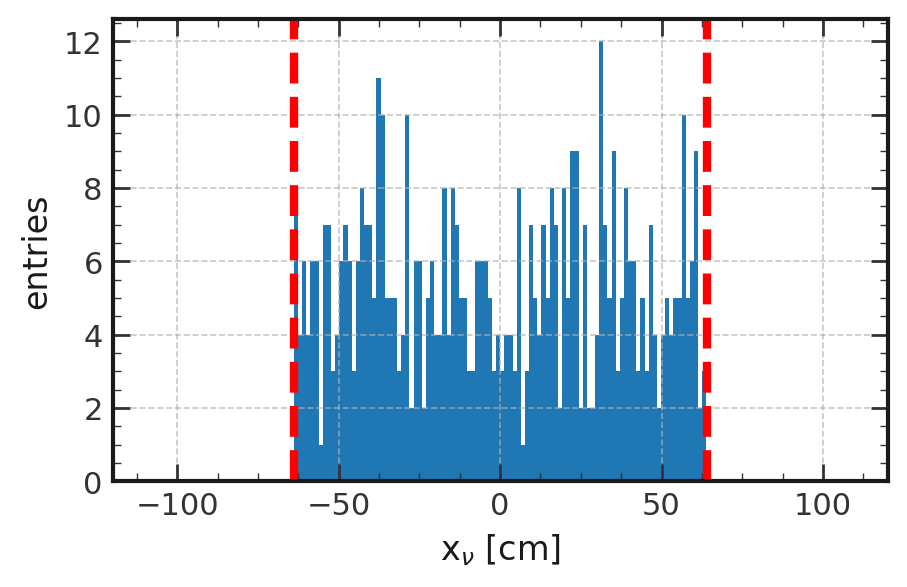

In [7]:
plt.hist(nu_x, histtype='stepfilled', stacked=True, bins=100)
plt.xlabel("x$_{\\nu}$ [cm]")
plt.ylabel("entries")
plt.axvline(anode_xs[0],0,1,ls="--",lw=3.,color='red')
plt.axvline(anode_xs[-1],0,1,ls="--",lw=3.,color='red')
plt.xlim(-120,120)
plt.savefig(plot_dir + "nu_vertex_x.png",bbox_inches="tight")
plt.savefig(plot_dir + "nu_vertex_x.pdf",bbox_inches="tight")
plt.show()

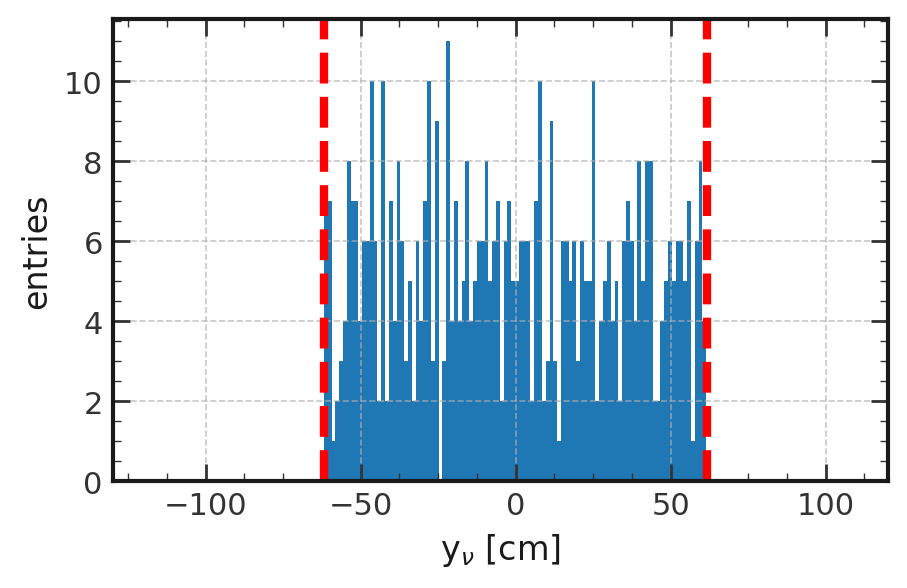

In [8]:
plt.hist(nu_y, histtype='stepfilled', bins=100)
plt.xlabel("y$_{\\nu}$ [cm]")
plt.ylabel("entries")
plt.axvline(anode_ys[0],0,1,ls="--",lw=3.,color='red')
plt.axvline(anode_ys[-1],0,1,ls="--",lw=3.,color='red')
plt.xlim(-130,120)
plt.savefig(plot_dir + "nu_vertex_y.png",bbox_inches="tight")
plt.savefig(plot_dir + "nu_vertex_y.pdf",bbox_inches="tight")
plt.show()

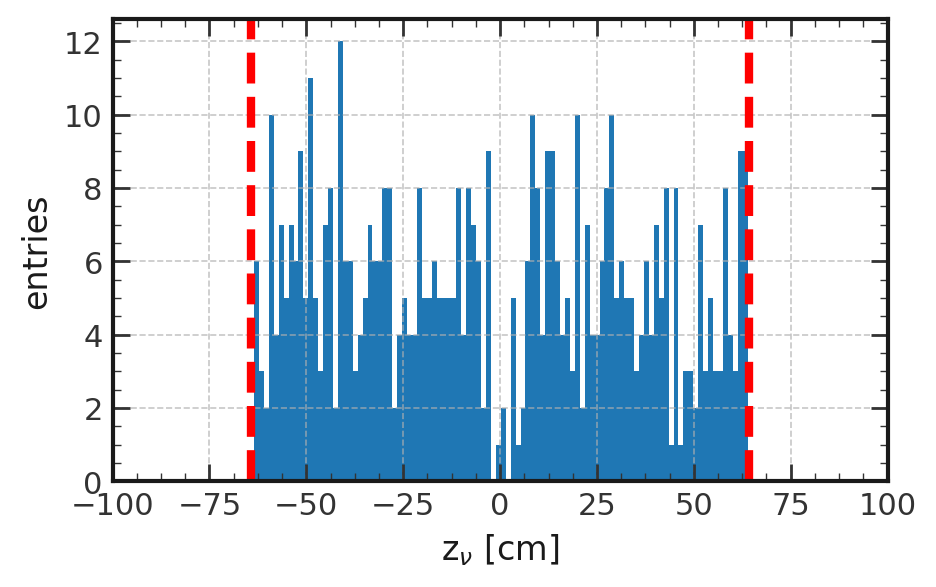

In [9]:
plt.hist(nu_z, histtype='stepfilled', bins=100)
plt.xlabel("z$_{\\nu}$ [cm]")
plt.ylabel("entries")
plt.axvline(anode_zs[0],0,1,ls="--",lw=3.,color='red')
plt.axvline(anode_zs[-1],0,1,ls="--",lw=3.,color='red')
plt.xlim(-100,100)
plt.savefig(plot_dir + "nu_vertex_z.png",bbox_inches="tight")
plt.savefig(plot_dir + "nu_vertex_z.pdf",bbox_inches="tight")
plt.show()

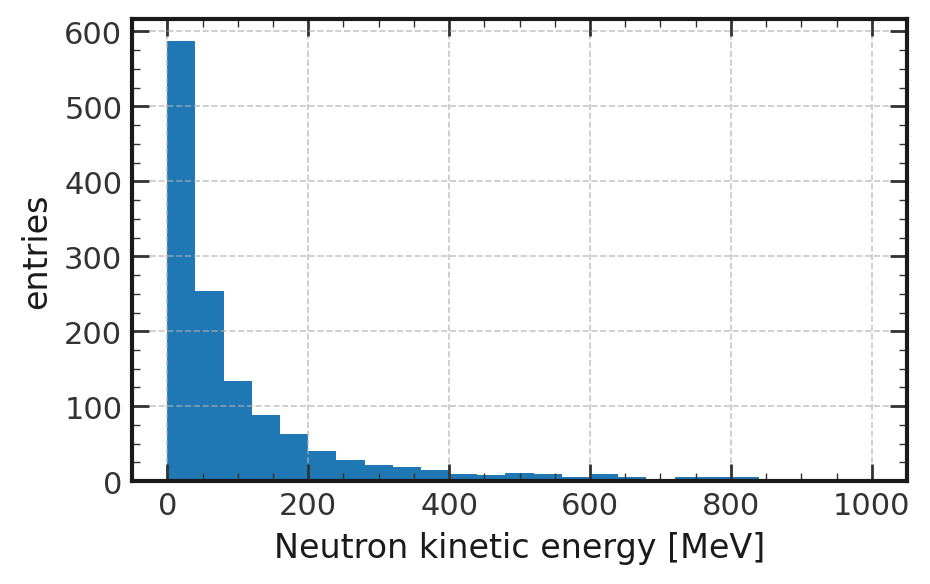

In [10]:
plt.hist(np.array(neutron_prim_traj)['E_start'] - neutron_mass, histtype='stepfilled',bins=25, range=(0,1000))
plt.xlabel("Neutron kinetic energy [MeV]")
plt.ylabel("entries")
plt.savefig(plot_dir + "neutron_primary_energy.png",bbox_inches="tight")
plt.savefig(plot_dir + "neutron_primary_energy.pdf",bbox_inches="tight")
plt.show()

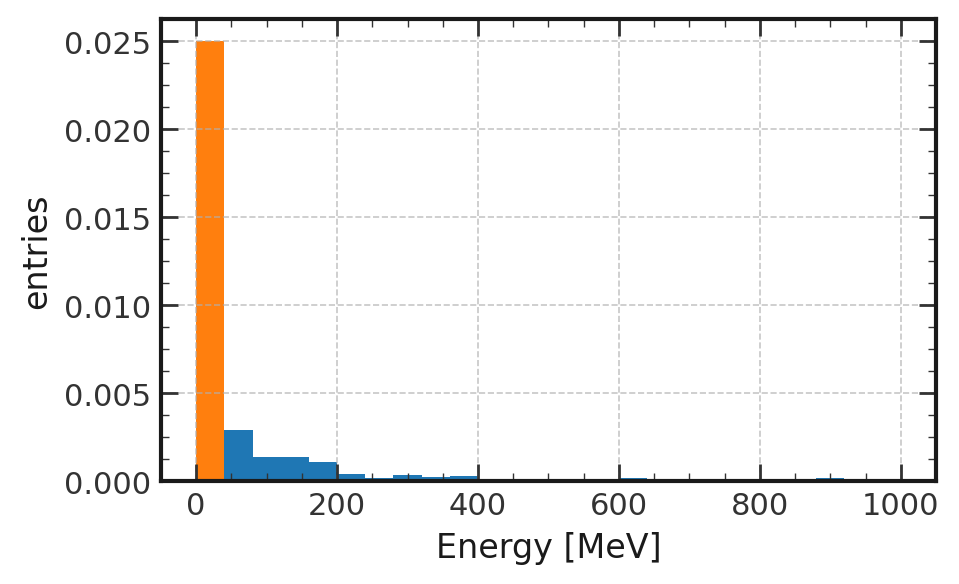

In [13]:
plt.hist(np.array(proton_n_daughter_traj)['E_start'] - ParticleCode().proton_mass, histtype='stepfilled',bins=25, range=(0,1000),density=True)
plt.xlabel("Energy [MeV]")
plt.ylabel("entries")
plt.savefig(plot_dir + "neutron_primary_energy.png",bbox_inches="tight")
plt.savefig(plot_dir + "neutron_primary_energy.pdf",bbox_inches="tight")
plt.show()

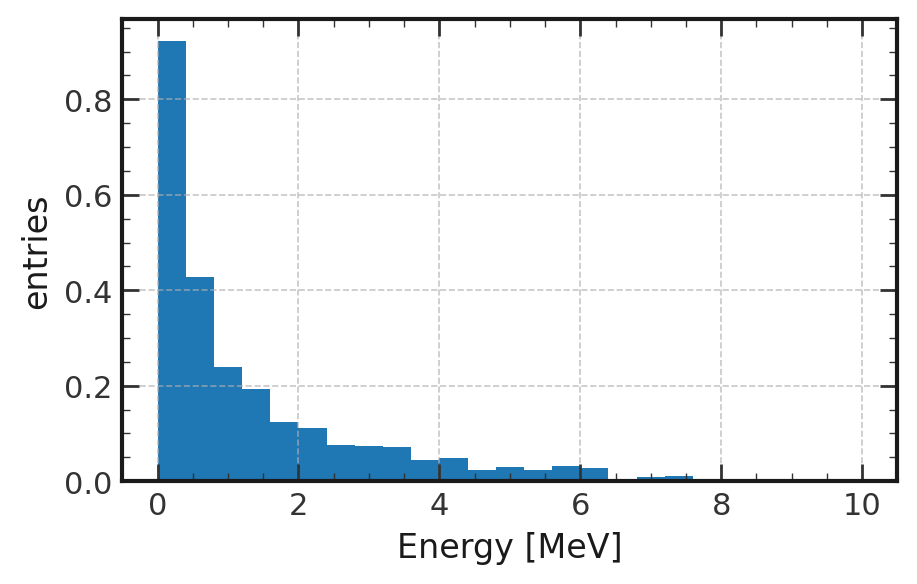

In [15]:
plt.hist(np.array(photon_n_daughter_traj)['E_start'], histtype='stepfilled',bins=25, range=(0,10),density=True)
plt.xlabel("Energy [MeV]")
plt.ylabel("entries")
plt.savefig(plot_dir + "photon_n_sec_energy.png",bbox_inches="tight")
plt.savefig(plot_dir + "photon_n_sec_energy.pdf",bbox_inches="tight")
plt.show()